In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install lightgbm

In [3]:
from  datetime import datetime, timedelta
import gc
import numpy as np, pandas as pd
import lightgbm as lgb

pd.options.display.max_columns = 50

In [4]:
CAL_DTYPES={"event_name_1": "category", "event_name_2": "category", "event_type_1": "category", 
         "event_type_2": "category", "weekday": "category", 'wm_yr_wk': 'int16', "wday": "int16",
        "month": "int16", "year": "int16", "snap_CA": "float32", 'snap_TX': 'float32', 'snap_WI': 'float32' }
PRICE_DTYPES = {"store_id": "category", "item_id": "category", "wm_yr_wk": "int16","sell_price":"float32" }

In [5]:
#parametres de base
h = 28 
max_lags = 57
tr_last = 1913
fday = datetime(2016,4, 25) 
fday

datetime.datetime(2016, 4, 25, 0, 0)

In [10]:
def create_dt(is_train = True, nrows = None, first_day = 1200):
    prices = pd.read_csv("/Users/jerem/cours_esiee_paris/E4/kaggle_walmart/data/sell_prices.csv", dtype = PRICE_DTYPES)
    for col, col_dtype in PRICE_DTYPES.items():
        if col_dtype == "category":
            prices[col] = prices[col].cat.codes.astype("int16")
            prices[col] -= prices[col].min()
            
    cal = pd.read_csv("/Users/jerem/cours_esiee_paris/E4/kaggle_walmart/data/calendar.csv", dtype = CAL_DTYPES)
    cal["date"] = pd.to_datetime(cal["date"])
    for col, col_dtype in CAL_DTYPES.items():
        if col_dtype == "category":
            cal[col] = cal[col].cat.codes.astype("int16")
            cal[col] -= cal[col].min()
    
    start_day = max(1 if is_train  else tr_last-max_lags, first_day)
    numcols = [f"d_{day}" for day in range(start_day,tr_last+1)]
    catcols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']
    dtype = {numcol:"float32" for numcol in numcols} 
    dtype.update({col: "category" for col in catcols if col != "id"})
    dt = pd.read_csv("/Users/jerem/cours_esiee_paris/E4/kaggle_walmart/data/sales_train_validation.csv", 
                     nrows = nrows, usecols = catcols + numcols, dtype = dtype)
    
    for col in catcols:
        if col != "id":
            dt[col] = dt[col].cat.codes.astype("int16")
            dt[col] -= dt[col].min()
    
    if not is_train:
        for day in range(tr_last+1, tr_last+ 28 +1):
            dt[f"d_{day}"] = np.nan
    
    dt = pd.melt(dt,
                  id_vars = catcols,
                  value_vars = [col for col in dt.columns if col.startswith("d_")],
                  var_name = "d",
                  value_name = "sales")
    
    dt = dt.merge(cal, on= "d", copy = False)
    dt = dt.merge(prices, on = ["store_id", "item_id", "wm_yr_wk"], copy = False)
    
    return dt

In [11]:
def create_fea(dt):
    lags = [7, 28]
    lag_cols = [f"lag_{lag}" for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        dt[lag_col] = dt[["id","sales"]].groupby("id")["sales"].shift(lag)

    wins = [7, 28]
    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            dt[f"rmean_{lag}_{win}"] = dt[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean())

    
    
    date_features = {
        
        "wday": "weekday",
        "week": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",
#         "ime": "is_month_end",
#         "ims": "is_month_start",
    }
    
#     dt.drop(["d", "wm_yr_wk", "weekday"], axis=1, inplace = True)
    
    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in dt.columns:
            dt[date_feat_name] = dt[date_feat_name].astype("int16")
        else:
            dt[date_feat_name] = getattr(dt["date"].dt, date_feat_func).astype("int16")

In [20]:
FIRST_DAY = 1548 # réduire le premier jour amene souvent à un dépassement de mémoire

In [21]:
%%time

df = create_dt(is_train=True, first_day= FIRST_DAY)
df.shape

CPU times: user 11.5 s, sys: 1.76 s, total: 13.3 s
Wall time: 11.6 s


(11126888, 22)

In [22]:
df.head()

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1548,2.0,2015-04-25,11513,2,1,4,2015,0,0,0,0,0.0,0.0,0.0,8.26
1,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1549,0.0,2015-04-26,11513,3,2,4,2015,0,0,0,0,0.0,0.0,0.0,8.26
2,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1550,1.0,2015-04-27,11513,1,3,4,2015,0,0,0,0,0.0,0.0,0.0,8.26
3,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1551,0.0,2015-04-28,11513,5,4,4,2015,0,0,0,0,0.0,0.0,0.0,8.26
4,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1552,0.0,2015-04-29,11513,6,5,4,2015,0,0,0,0,0.0,0.0,0.0,8.26


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11126888 entries, 0 to 11126887
Data columns (total 22 columns):
id              object
item_id         int16
dept_id         int16
store_id        int16
cat_id          int16
state_id        int16
d               object
sales           float32
date            datetime64[ns]
wm_yr_wk        int16
weekday         int16
wday            int16
month           int16
year            int16
event_name_1    int16
event_type_1    int16
event_name_2    int16
event_type_2    int16
snap_CA         float32
snap_TX         float32
snap_WI         float32
sell_price      float32
dtypes: datetime64[ns](1), float32(5), int16(14), object(2)
memory usage: 848.9+ MB


In [24]:
%%time

create_fea(df)
df.shape

CPU times: user 1min 38s, sys: 5.65 s, total: 1min 44s
Wall time: 1min 33s


(11126888, 31)

In [25]:
df.head()

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_7,lag_28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,week,quarter,mday
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1548,2.0,2015-04-25,11513,2,1,4,2015,0,0,0,0,0.0,0.0,0.0,8.26,NaN,NaN,NaN,NaN,NaN,NaN,17,2,25
1,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1549,0.0,2015-04-26,11513,3,2,4,2015,0,0,0,0,0.0,0.0,0.0,8.26,NaN,NaN,NaN,NaN,NaN,NaN,17,2,26
2,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1550,1.0,2015-04-27,11513,1,3,4,2015,0,0,0,0,0.0,0.0,0.0,8.26,NaN,NaN,NaN,NaN,NaN,NaN,18,2,27
3,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1551,0.0,2015-04-28,11513,5,4,4,2015,0,0,0,0,0.0,0.0,0.0,8.26,NaN,NaN,NaN,NaN,NaN,NaN,18,2,28
4,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1552,0.0,2015-04-29,11513,6,5,4,2015,0,0,0,0,0.0,0.0,0.0,8.26,NaN,NaN,NaN,NaN,NaN,NaN,18,2,29


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11126888 entries, 0 to 11126887
Data columns (total 31 columns):
id              object
item_id         int16
dept_id         int16
store_id        int16
cat_id          int16
state_id        int16
d               object
sales           float32
date            datetime64[ns]
wm_yr_wk        int16
weekday         int16
wday            int16
month           int16
year            int16
event_name_1    int16
event_type_1    int16
event_name_2    int16
event_type_2    int16
snap_CA         float32
snap_TX         float32
snap_WI         float32
sell_price      float32
lag_7           float32
lag_28          float32
rmean_7_7       float32
rmean_28_7      float32
rmean_7_28      float32
rmean_28_28     float32
week            int16
quarter         int16
mday            int16
dtypes: datetime64[ns](1), float32(11), int16(17), object(2)
memory usage: 1.1+ GB


In [27]:
fourier = pd.read_csv('/Users/jerem/cours_esiee_paris/E4/kaggle_walmart/fourier_each_item.csv')
fourier

,id,d_1548,d_1549,d_1550,d_1551,d_1552,d_1553,d_1554,d_1555,d_1556,d_1557,d_1558,d_1559,d_1560,d_1561,d_1562,d_1563,d_1564,d_1565,d_1566,d_1567,d_1568,d_1569,d_1570,d_1571,...,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,FOODS_1_001_CA_1_validation,0.674633,0.737291,0.523595,0.589511,0.530512,0.139542,0.563851,0.675903,0.295615,0.833246,0.608314,0.386414,0.176856,0.296465,0.702267,0.237263,0.805848,1.014768,0.245635,0.545772,0.486667,0.427390,0.567793,0.742189,...,0.494783,1.270253,0.793695,1.004630,1.265444,0.869056,0.745685,0.518805,0.990796,0.842615,0.690526,1.448386,0.830743,0.541138,0.812864,0.522082,0.649667,0.632877,1.072808,0.950150,0.314333,0.851343,0.429533,0.114580,0.741544
1,FOODS_1_001_CA_2_validation,1.588128,0.733491,0.123893,1.365974,1.219625,0.844823,1.081791,0.549487,0.690712,0.416591,0.162372,1.499492,1.229259,0.360858,0.891389,0.641329,0.707630,1.071875,0.973970,1.846102,1.394377,0.322700,1.220205,1.324160,...,0.259098,1.305190,1.012452,1.050950,0.843196,0.432603,0.890186,0.206326,0.307346,1.636248,1.037694,0.609011,0.854470,0.555493,1.067771,0.989406,1.035258,2.069586,1.170895,0.475853,1.282107,1.138495,1.350810,1.495057,1.139127
2,FOODS_1_001_CA_3_validation,1.958086,0.767862,0.686620,0.654127,1.776228,1.931919,0.975390,2.129279,1.621855,0.029826,0.876885,1.404141,1.558120,1.530375,0.780989,1.387348,0.587870,0.614575,1.178464,1.545369,0.687046,0.949779,0.473174,0.441033,...,1.105820,0.254431,1.742020,2.229247,0.355062,0.496377,0.626275,0.304832,0.708315,0.608795,1.589562,1.303831,0.607532,0.314427,0.869918,0.130168,1.055270,1.361907,1.266157,0.705037,0.366896,1.055044,1.559367,0.597559,1.880193
3,FOODS_1_001_CA_4_validation,0.395325,0.220562,0.139595,0.384551,0.258299,0.304940,0.426002,0.205262,0.144646,0.243818,0.616664,0.215071,0.685806,0.370667,0.148287,0.657944,0.492276,0.387412,0.004963,0.447081,0.220435,0.114906,0.452783,0.154163,...,0.272912,0.379829,0.867445,0.077045,0.260055,0.321848,0.271287,0.273102,0.133781,0.246207,0.209748,0.483620,0.392718,0.012735,0.309294,0.305422,0.557659,0.304791,0.622486,0.276241,0.216536,0.846667,0.300178,0.257675,0.160741
4,FOODS_1_001_TX_1_validation,0.057722,0.041872,0.186977,1.129886,0.927472,0.000002,0.792661,0.493181,0.246220,0.256260,0.031094,0.368998,0.134808,1.059917,1.306626,0.059938,0.475456,0.679391,0.242200,0.243491,0.085664,0.768021,0.608709,0.842847,...,0.713888,0.492794,0.025185,0.837495,0.696851,0.313506,0.415920,0.191590,0.688820,0.036859,0.470389,0.827218,0.086888,0.626687,0.547390,0.157232,0.334654,0.292669,0.999014,0.418376,0.200649,0.935617,0.277866,0.395747,0.376730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_validation,0.246105,0.461133,0.497872,0.350600,0.222434,0.551000,0.174454,0.392321,0.693459,0.342744,0.350733,0.224513,0.269880,0.032189,0.229167,0.539644,0.057256,0.280516,0.250182,0.076768,0.217913,0.391771,0.623001,0.254792,...,0.319168,0.273877,0.132421,0.259724,0.297793,0.107027,0.546568,0.376661,0.277195,0.199914,0.420060,0.465254,0.275299,0.755945,0.399249,0.169517,0.335265,0.205787,0.260111,0.205026,0.514255,0.175970,0.024263,0.355368,0.048167
30486,HOUSEHOLD_2_516_TX_3_validation,0.098045,0.119822,0.010789,0.230448,0.149759,0.445187,0.111757,0.136390,0.283040,0.105612,0.059382,0.052680,0.191327,0.263473,0.317415,0.083440,0.516217,0.228741,0.216528,0.100683,0.163966,0.212344,0.212808,0.095768,...,0.432164,0.221694,0.198806,0.054390,0.028526,0.145544,0.126326,0.010562,0.177747,0.374089,0.107302,0.271228,0.001456,0.233440,0.053524,0.056868,0.020235,0.265230,0.082240,0.195459,0.183211,0.200833,0.321445,0.087381,0.072461
30487,HOUSEHOLD_2_516_WI_1_validation,0.004875,0.152489,0.087394,0.062160,0.036468,0.049736,0.112129

In [29]:
fourier = pd.melt(fourier,id_vars = 'id',
                  value_vars = [col for col in fourier.columns if col.startswith("d_")],
                  var_name = "d",
                  value_name = "sales")

In [31]:
fourier

,id,d,sales
0,FOODS_1_001_CA_1_validation,d_1548,0.674633
1,FOODS_1_001_CA_2_validation,d_1548,1.588128
2,FOODS_1_001_CA_3_validation,d_1548,1.958086
3,FOODS_1_001_CA_4_validation,d_1548,0.395325
4,FOODS_1_001_TX_1_validation,d_1548,0.057722
...,...,...,...
11159335,HOUSEHOLD_2_516_TX_2_validation,d_1913,0.048167
11159336,HOUSEHOLD_2_516_TX_3_validation,d_1913,0.072461
11159337,HOUSEHOLD_2_516_WI_1_validation,d_1913,0.009829
11159338,HOUSEHOLD_2_516_WI_2_validation,d_1913,0.048515


In [32]:
df

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_7,lag_28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,week,quarter,mday
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1548,2.0,2015-04-25,11513,2,1,4,2015,0,0,0,0,0.0,0.0,0.0,8.26,NaN,NaN,NaN,NaN,NaN,NaN,17,2,25
1,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1549,0.0,2015-04-26,11513,3,2,4,2015,0,0,0,0,0.0,0.0,0.0,8.26,NaN,NaN,NaN,NaN,NaN,NaN,17,2,26
2,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1550,1.0,2015-04-27,11513,1,3,4,2015,0,0,0,0,0.0,0.0,0.0,8.26,NaN,NaN,NaN,NaN,NaN,NaN,18,2,27
3,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1551,0.0,2015-04-28,11513,5,4,4,2015,0,0,0,0,0.0,0.0,0.0,8.26,NaN,NaN,NaN,NaN,NaN,NaN,18,2,28
4,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1552,0.0,2015-04-29,11513,6,5,4,2015,0,0,0,0,0.0,0.0,0.0,8.26,NaN,NaN,NaN,NaN,NaN,NaN,18,2,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11126883,FOODS_3_825_WI_3_validation,3046,6,9,2,2,d_1913,0.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,3.98,0.0,1.0,1.000000,0.714286,0.928571,1.250000,16,2,24
11126884,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1912,1.0,2016-04-23,11613,2,1,4,2016,0,0,0,0,0.0,0.0,0.0,1.28,0.0,2.0,0.857143,1.142857,1.035714,1.107143,16,2,23
11126885,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1913,3.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,1.28,1.0,4.0,0.714286,1.571429,1.035714,1.250000,16,2,24
11126886,FOODS_3_827_WI_3_validation,3048,6,9,2,2,d_1912,0.0,2016-04-23,11613,2,1,4,2016,0,0,0,0,0.0,0.0,0.0,1.00,0.0,0.0,0.000000,2.285714,1.821429,1.785714,16,2,23


In [33]:
%%time
df_with_fourier = df.merge(fourier,on=['id','d'], how='inner')

CPU times: user 10.9 s, sys: 1.97 s, total: 12.8 s
Wall time: 12.2 s


In [37]:
df_with_fourier = df_with_fourier.rename(columns = {'sales_x':'sales','sales_y':'fourier'})

In [38]:
df_with_fourier

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_7,lag_28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,week,quarter,mday,fourier
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1548,2.0,2015-04-25,11513,2,1,4,2015,0,0,0,0,0.0,0.0,0.0,8.26,NaN,NaN,NaN,NaN,NaN,NaN,17,2,25,0.164690
1,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1549,0.0,2015-04-26,11513,3,2,4,2015,0,0,0,0,0.0,0.0,0.0,8.26,NaN,NaN,NaN,NaN,NaN,NaN,17,2,26,0.387007
2,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1550,1.0,2015-04-27,11513,1,3,4,2015,0,0,0,0,0.0,0.0,0.0,8.26,NaN,NaN,NaN,NaN,NaN,NaN,18,2,27,0.246072
3,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1551,0.0,2015-04-28,11513,5,4,4,2015,0,0,0,0,0.0,0.0,0.0,8.26,NaN,NaN,NaN,NaN,NaN,NaN,18,2,28,0.851850
4,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1552,0.0,2015-04-29,11513,6,5,4,2015,0,0,0,0,0.0,0.0,0.0,8.26,NaN,NaN,NaN,NaN,NaN,NaN,18,2,29,0.622020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11126883,FOODS_3_825_WI_3_validation,3046,6,9,2,2,d_1913,0.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,3.98,0.0,1.0,1.000000,0.714286,0.928571,1.250000,16,2,24,0.493849
11126884,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1912,1.0,2016-04-23,11613,2,1,4,2016,0,0,0,0,0.0,0.0,0.0,1.28,0.0,2.0,0.857143,1.142857,1.035714,1.107143,16,2,23,1.226139
11126885,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1913,3.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,1.28,1.0,4.0,0.714286,1.571429,1.035714,1.250000,16,2,24,1.476346
11126886,FOODS_3_827_WI_3_validation,3048,6,9,2,2,d_1912,0.0,2016-04-23,11613,2,1,4,2016,0,0,0,0,0.0,0.0,0.0,1.00,0.0,0.0,0.000000,2.285714,1.821429,1.785714,16,2,23,1.563841


In [41]:
df = df_with_fourier
df

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_7,lag_28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,week,quarter,mday,fourier
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1548,2.0,2015-04-25,11513,2,1,4,2015,0,0,0,0,0.0,0.0,0.0,8.26,NaN,NaN,NaN,NaN,NaN,NaN,17,2,25,0.164690
1,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1549,0.0,2015-04-26,11513,3,2,4,2015,0,0,0,0,0.0,0.0,0.0,8.26,NaN,NaN,NaN,NaN,NaN,NaN,17,2,26,0.387007
2,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1550,1.0,2015-04-27,11513,1,3,4,2015,0,0,0,0,0.0,0.0,0.0,8.26,NaN,NaN,NaN,NaN,NaN,NaN,18,2,27,0.246072
3,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1551,0.0,2015-04-28,11513,5,4,4,2015,0,0,0,0,0.0,0.0,0.0,8.26,NaN,NaN,NaN,NaN,NaN,NaN,18,2,28,0.851850
4,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1552,0.0,2015-04-29,11513,6,5,4,2015,0,0,0,0,0.0,0.0,0.0,8.26,NaN,NaN,NaN,NaN,NaN,NaN,18,2,29,0.622020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11126883,FOODS_3_825_WI_3_validation,3046,6,9,2,2,d_1913,0.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,3.98,0.0,1.0,1.000000,0.714286,0.928571,1.250000,16,2,24,0.493849
11126884,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1912,1.0,2016-04-23,11613,2,1,4,2016,0,0,0,0,0.0,0.0,0.0,1.28,0.0,2.0,0.857143,1.142857,1.035714,1.107143,16,2,23,1.226139
11126885,FOODS_3_826_WI_3_validation,3047,6,9,2,2,d_1913,3.0,2016-04-24,11613,3,2,4,2016,0,0,0,0,0.0,0.0,0.0,1.28,1.0,4.0,0.714286,1.571429,1.035714,1.250000,16,2,24,1.476346
11126886,FOODS_3_827_WI_3_validation,3048,6,9,2,2,d_1912,0.0,2016-04-23,11613,2,1,4,2016,0,0,0,0,0.0,0.0,0.0,1.00,0.0,0.0,0.000000,2.285714,1.821429,1.785714,16,2,23,1.563841


In [42]:
df.dropna(inplace = True)
df.shape

(9449938, 32)

In [43]:
cat_feats = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id'] + ["event_name_1", "event_name_2", "event_type_1", "event_type_2"]
useless_cols = ["id", "date", "sales","d", "wm_yr_wk", "weekday"]
train_cols = df.columns[~df.columns.isin(useless_cols)]
X_train = df[train_cols]
y_train = df["sales"]

In [45]:
%%time

np.random.seed(777)

fake_valid_inds = np.random.choice(X_train.index.values, 2_000_000, replace = False)
train_inds = np.setdiff1d(X_train.index.values, fake_valid_inds)
train_data = lgb.Dataset(X_train.loc[train_inds] , label = y_train.loc[train_inds], 
                         categorical_feature=cat_feats, free_raw_data=False)
fake_valid_data = lgb.Dataset(X_train.loc[fake_valid_inds], label = y_train.loc[fake_valid_inds],
                              categorical_feature=cat_feats,
                 free_raw_data=False)

CPU times: user 6.5 s, sys: 687 ms, total: 7.18 s
Wall time: 5.27 s


In [46]:
del df, X_train, y_train, fake_valid_inds,train_inds ; gc.collect()

20

In [47]:
params = {
        "objective" : "poisson",
        "metric" :"rmse",
        "force_row_wise" : True,
        "learning_rate" : 0.075,
#         "sub_feature" : 0.8,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
        "lambda_l2" : 0.1,
#         "nthread" : 4
        "metric": ["rmse"],
    'verbosity': 1,
    'num_iterations' : 1200,
    'num_leaves': 128,
    "min_data_in_leaf": 100,
}

In [48]:
%%time

m_lgb = lgb.train(params, train_data, valid_sets = [fake_valid_data], verbose_eval=20) 

/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/jerem/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[20]	valid_0's rmse: 2.40399
[40]	valid_0's rmse: 2.09376
[60]	valid_0's rmse: 2.01913
[80]	valid_0's rmse: 1.999
[100]	valid_0's rmse: 1.9913
[120]	valid_0's rmse: 1.98581
[140]	valid_0's rmse: 1.98027
[160]	valid_0's rmse: 1.97654
[180]	valid_0's rmse: 1.97247
[200]	valid_0's rmse: 1.96938
[220]	valid_0's rmse: 1.96451
[240]	valid_0's rmse: 1.95979
[260]	valid_0's rmse: 1.95754
[280]	valid_0's rmse: 1.95461
[300]	valid_0's rmse: 1.95125
[320]	valid_0's rmse: 1.94932
[340]	valid_0's rmse: 1.94699
[360]	valid_0's rmse: 1.94427
[380]	valid_0's rmse: 1.94242
[400]	valid_0's rmse: 1.94129
[420]	valid_0's rmse: 1.93958
[440]	valid_0's rmse: 1.93793
[460]	valid_0's rmse: 1.93651
[480]	valid_0's rmse: 1.93531
[500]	valid_0's rmse: 1.93408
[520]	valid_0's rmse: 1.93266
[540]	valid_0's rmse: 1.93137
[560]	valid_0's rmse: 1.93078
[580]	valid_0's rmse: 1.92983
[600]	valid_0's rmse: 1.92878
[620]	valid_0's rmse: 1.92826
[640]	valid_0's rmse: 1.92746
[660]	valid_0's rmse: 1.92689
[680]	valid_0's r

In [ ]:
m_lgb.save_model("model_with_fourier.lgb")

NameError: name 'lgb' is not defined

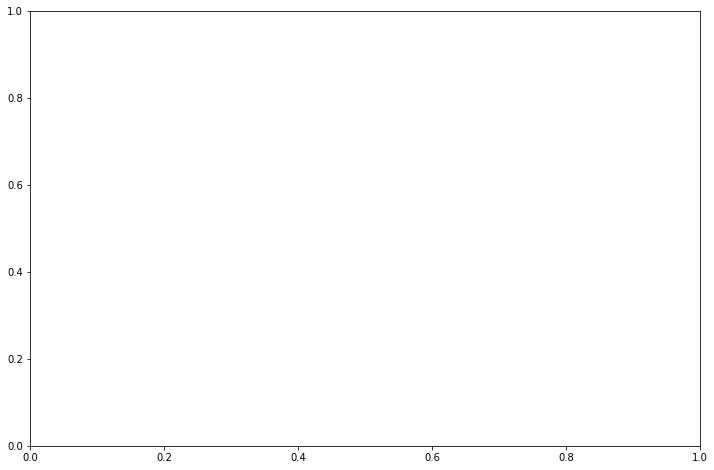

In [1]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (18.0, 4)
%matplotlib inline 

fig, ax = plt.subplots(figsize=(12,8))
lgb.plot_importance(m_lgb, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("Feature Importance", fontsize=15)
plt.show()

In [49]:
%%time

alphas = [1.028, 1.023, 1.018]
weights = [1/len(alphas)]*len(alphas)
sub = 0.

for icount, (alpha, weight) in enumerate(zip(alphas, weights)):

    te = create_dt(False)
    cols = [f"F{i}" for i in range(1,29)]

    for tdelta in range(0, 28):
        day = fday + timedelta(days=tdelta)
        print(tdelta, day)
        tst = te[(te.date >= day - timedelta(days=max_lags)) & (te.date <= day)].copy()
        create_fea(tst)
        tst = tst.loc[tst.date == day , train_cols]
        # 28 prédictions
        te.loc[te.date == day, "sales"] = alpha*m_lgb.predict(tst) # evite l'overfitting



    te_sub = te.loc[te.date >= fday, ["id", "sales"]].copy()
#     te_sub.loc[te.date >= fday+ timedelta(days=h), "id"] = te_sub.loc[te.date >= fday+timedelta(days=h), 
#                                                                           "id"].str.replace("validation$", "evaluation")
    te_sub["F"] = [f"F{rank}" for rank in te_sub.groupby("id")["id"].cumcount()+1]
    te_sub = te_sub.set_index(["id", "F" ]).unstack()["sales"][cols].reset_index()
    te_sub.fillna(0., inplace = True)
    te_sub.sort_values("id", inplace = True)
    te_sub.reset_index(drop=True, inplace = True)
    te_sub.to_csv(f"submission_{icount}.csv",index=False)
    if icount == 0 :
        sub = te_sub
        sub[cols] *= weight
    else:
        sub[cols] += te_sub[cols]*weight
    print(icount, alpha, weight)


sub2 = sub.copy()
sub2["id"] = sub2["id"].str.replace("validation$", "evaluation")
sub = pd.concat([sub, sub2], axis=0, sort=False)
sub.to_csv("submission_with_fourier.csv",index=False)

0 2016-04-25 00:00:00


/Users/jerem/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


1 2016-04-26 00:00:00
2 2016-04-27 00:00:00
3 2016-04-28 00:00:00
4 2016-04-29 00:00:00
5 2016-04-30 00:00:00
6 2016-05-01 00:00:00
7 2016-05-02 00:00:00
8 2016-05-03 00:00:00
9 2016-05-04 00:00:00
10 2016-05-05 00:00:00
11 2016-05-06 00:00:00
12 2016-05-07 00:00:00
13 2016-05-08 00:00:00
14 2016-05-09 00:00:00
15 2016-05-10 00:00:00
16 2016-05-11 00:00:00
17 2016-05-12 00:00:00
18 2016-05-13 00:00:00
19 2016-05-14 00:00:00
20 2016-05-15 00:00:00
21 2016-05-16 00:00:00
22 2016-05-17 00:00:00
23 2016-05-18 00:00:00
24 2016-05-19 00:00:00
25 2016-05-20 00:00:00
26 2016-05-21 00:00:00
27 2016-05-22 00:00:00
0 1.028 0.3333333333333333
0 2016-04-25 00:00:00


/Users/jerem/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


1 2016-04-26 00:00:00
2 2016-04-27 00:00:00
3 2016-04-28 00:00:00
4 2016-04-29 00:00:00
5 2016-04-30 00:00:00
6 2016-05-01 00:00:00
7 2016-05-02 00:00:00
8 2016-05-03 00:00:00
9 2016-05-04 00:00:00
10 2016-05-05 00:00:00
11 2016-05-06 00:00:00
12 2016-05-07 00:00:00
13 2016-05-08 00:00:00
14 2016-05-09 00:00:00
15 2016-05-10 00:00:00
16 2016-05-11 00:00:00
17 2016-05-12 00:00:00
18 2016-05-13 00:00:00
19 2016-05-14 00:00:00
20 2016-05-15 00:00:00
21 2016-05-16 00:00:00
22 2016-05-17 00:00:00
23 2016-05-18 00:00:00
24 2016-05-19 00:00:00
25 2016-05-20 00:00:00
26 2016-05-21 00:00:00
27 2016-05-22 00:00:00
1 1.023 0.3333333333333333
0 2016-04-25 00:00:00


/Users/jerem/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


1 2016-04-26 00:00:00
2 2016-04-27 00:00:00
3 2016-04-28 00:00:00
4 2016-04-29 00:00:00
5 2016-04-30 00:00:00
6 2016-05-01 00:00:00
7 2016-05-02 00:00:00
8 2016-05-03 00:00:00
9 2016-05-04 00:00:00
10 2016-05-05 00:00:00
11 2016-05-06 00:00:00
12 2016-05-07 00:00:00
13 2016-05-08 00:00:00
14 2016-05-09 00:00:00
15 2016-05-10 00:00:00
16 2016-05-11 00:00:00
17 2016-05-12 00:00:00
18 2016-05-13 00:00:00
19 2016-05-14 00:00:00
20 2016-05-15 00:00:00
21 2016-05-16 00:00:00
22 2016-05-17 00:00:00
23 2016-05-18 00:00:00
24 2016-05-19 00:00:00
25 2016-05-20 00:00:00
26 2016-05-21 00:00:00
27 2016-05-22 00:00:00
2 1.018 0.3333333333333333
CPU times: user 2h 28min 29s, sys: 3min 27s, total: 2h 31min 56s
Wall time: 1h 43min 24s
